In [6]:
import pandas as pd
from pandasql import sqldf
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import linear_model
import statsmodels.api as sm

In [8]:
# Lecture 1 Exercise 2, Estimate Betas
nasdaq = pd.read_sas("crsp_nasdaq100_1999to2021.sas7bdat", encoding = 'latin-1')
nasdaq["yyyymm"] = nasdaq.DATE.dt.year*100 + nasdaq.DATE.dt.month
nasdaq["monthid"] = (nasdaq.DATE.dt.year-2000)*12 + nasdaq.DATE.dt.month

ff_factors = pd.read_sas("factors_monthly.sas7bdat", encoding = 'latin-1')
# ff_factors["yyyymm"] = ff_factors.dateff.dt.year*100 + ff_factors.dateff.dt.month
ff_factors["monthid"] = (ff_factors.dateff.dt.year-2000)*12 + ff_factors.dateff.dt.month

#print(nasdaq)
#print(ff_factors)
ret_matrix = pd.merge(nasdaq, ff_factors, on="monthid")
ret_matrix["XRET"] = ret_matrix["RET"]-ret_matrix["rf"]
ret_matrix

KeyError: 'RF'

In [ ]:
ret_matrix = pd.merge(nasdaq, ff_factors, on="monthid")
ret_matrix["XRET"] = ret_matrix["RET"]-ret_matrix["RF"]
data = sqldf("SELECT i.PERMNO, i.monthid, j.monthid as monthid2, j.XRET, j.MKTRF, j.SMB, j.HML \
              FROM ret_matrix AS i, ret_matrix AS j \
              WHERE i.PERMNO = j.PERMNO AND i.monthid > j.monthid AND i.monthid <= j.monthid + 36")
dataSorted = data.sort_values(["PERMNO", "monthid", "monthid2"])
dataSorted["stock_monthid"] = dataSorted["PERMNO"].astype(str) + dataSorted["monthid"].astype(str)
dataSorted.dropna(inplace=True)
dataSorted

In [3]:
company_month_groups = dataSorted.groupby(["stock_monthid"])

beta = {'PERMNO':[], 'monthid':[], 'beta': [], 'ff3_beta':[], 'smb_beta':[], 'hml_beta':[]}

for name, group in company_month_groups:
    CAPMmodel = linear_model.LinearRegression().fit(group[["MKTRF"]], group["XRET"])
    ff3model = linear_model.LinearRegression().fit(group[["MKTRF", "SMB", "HML"]], group["XRET"])
    beta['PERMNO'].append(group['PERMNO'].iloc[0])
    beta['monthid'].append(group['monthid'].iloc[0])
    beta['beta'].append(CAPMmodel.coef_[0])
    beta['ff3_beta'].append(ff3model.coef_[0])
    beta['smb_beta'].append(ff3model.coef_[1])
    beta['hml_beta'].append(ff3model.coef_[2])
    
betaDF = pd.DataFrame(beta)
lecture1 = pd.merge(ret_matrix, betaDF, on=["PERMNO", "monthid"])
lecture1Sorted = lecture1.sort_values(["monthid", "beta"])
# lecture1Sorted

    
#     excess_ret = group["RET"]-group["RF"]
#     print(name)
#     print(stats.linregress(group["MKTRF"], excess_ret))

NameError: name 'dataSorted' is not defined

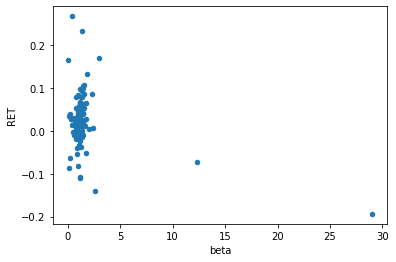

In [6]:
# Lecture 1 Exercise 2 plot

lecture1Sorted.loc[lecture1Sorted["yyyymm"]==201912].plot(kind = 'scatter', x = 'beta', y = 'RET')
# plt.xlim([0, 3])
plt.show()

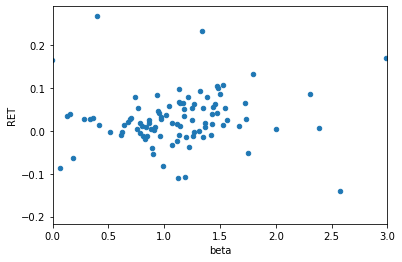

In [7]:
lecture1Sorted.loc[lecture1Sorted["yyyymm"]==201912].plot(kind = 'scatter', x = 'beta', y = 'RET')
plt.xlim([0, 3])
plt.show()

In [8]:
lecture1Sorted = lecture1Sorted.loc[(lecture1Sorted['yyyymm']>=200501) & (lecture1Sorted['yyyymm']<=202012)]

lecture1Sorted["beta_rank"] = lecture1Sorted.groupby(['monthid'])['beta'].transform(
                     lambda x: pd.qcut(x, 10, labels=False))

# lecture1Sorted["beta_rank"] = pd.qcut(lecture1Sorted["beta"], 10, labels = False)


# for name, group in lecture1Groups:
#     group["beta_rank"] = pd.qcut(group["beta"], 10, labels = False)

# lecture1Sorted = pd.concat(lecture1Groups)
    
# lecture1Sorted["beta_rank"] = pd.qcut(lecture1Sorted["beta"], 10, labels = False)
lecture1Sorted.sort_values(["monthid", "beta_rank"])

,PERMNO,DATE,CUSIP,COMNAM,TICKER,PERMCO,PRC,VOL,RET,SPREAD,...,HML,MKTRF,RF,UMD,XRET,beta,ff3_beta,smb_beta,hml_beta,beta_rank
5851,90319.0,2005-01-31,02079K30,GOOGLE INC,GOOG,45483.0,195.619995,2049127.0,0.014679,NaN,...,0.0207,-0.0276,0.0016,0.0319,0.013079,-14.403749,-21.847019,-7.958195,26.325421,0
5816,76709.0,2005-01-31,45168D10,I D E X X LABORATORIES INC,IDXX,10989.0,58.009998,43605.0,0.062649,NaN,...,0.0207,-0.0276,0.0016,0.0319,0.061049,0.203270,0.155163,-0.015507,-1.327135,0
5850,89525.0,2005-01-31,20030N10,COMCAST CORP NEW,CMCSA,43613.0,32.189999,1766967.0,-0.032752,NaN,...,0.0207,-0.0276,0.0016,0.0319,-0.034352,0.206282,0.405966,-0.474048,-1.010274,0
5818,76841.0,2005-01-31,09062X10,BIOGEN IDEC INC,BIIB,11112.0,64.959999,779225.0,-0.024771,NaN,...,0.0207,-0.0276,0.0016,0.0319,-0.026371,0.274328,0.271268,-0.598452,-1.580308,0
5796,21776.0,2005-01-31,30161N10,EXELON CORP,EXC,21396.0,44.250000,470691.0,0.004084,NaN,...,0.0207,-0.0276,0.0016,0.0319,0.002484,0.358467,0.382468,-0.035068,0.554934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21401,78987.0,2020-12-31,59501710,MICROCHIP TECHNOLOGY INC,MCHP,12027.0,138.110001,392265.0,0.027681,NaN,...,-0.0156,0.0463,0.0001,-0.0242,0.027581,1.698705,1.360423,1.069207,0.628464,9
21412,85913.0,2020-12-31,57190320,MARRIOTT INTERNATIONAL INC NEW,MAR,30005.0,131.919998,407301.0,0.039804,NaN,...,-0.0156,0.0463,0.0001,-0.0242,0.039704,1.802282,1.571845,0.325778,0.885104,9
21385,61241.0,2020-12-31,00790310,ADVANCED MICRO DEVICES INC,AMD,211.0,91.709999,8486992.0,-0.010253,NaN,...,-0.0156,0.0463,0.0001,-0.0242,-0.010353,1.907407,2.393067,-0.814301,-1.720439,9
21367,18312.0,2020-12-31,60770K10,MODERNA INC,MRNA,56611.0,104.470001,7560353.0,-0.316027,NaN,...,-0.0156,0.0463,0.0001,-0.0242,-0.316127,1.914044,1.371517,6.037883,-2.557471,9


In [9]:
# Lecture 1 2.2 Get deciles

lecture1Sorted["monthid_beta"] = lecture1Sorted["monthid"].astype(str) + lecture1Sorted["beta_rank"].astype(str)
betaGroups = lecture1Sorted.groupby(["monthid_beta"])

deciles = {'monthid':[], 'beta_rank':[], 'freq':[], 'return':[], 'beta':[], 'ff3_beta':[], 'smb_beta':[], 'hml_beta':[]}

for name, group in betaGroups:
    deciles['monthid'].append(group['monthid'].iloc[0])
    deciles['beta_rank'].append(group['beta_rank'].iloc[0])
    deciles['freq'].append(group.shape[0])
    deciles['return'].append(group['RET'].mean())
    deciles['beta'].append(group['beta'].mean())
    deciles['ff3_beta'].append(group['ff3_beta'].mean())
    deciles['smb_beta'].append(group['smb_beta'].mean())
    deciles['hml_beta'].append(group['hml_beta'].mean())

decilesDF = pd.DataFrame(deciles)
decilesDF.sort_values(["monthid", 'beta_rank'])

    


,monthid,beta_rank,freq,return,beta,ff3_beta,smb_beta,hml_beta
1530,61,0,7,0.000047,-1.777190,-2.807226,-1.319573,3.456129
1531,61,1,7,-0.046532,0.575520,0.566121,0.115233,0.036790
1532,61,2,7,-0.009728,0.842867,0.761716,0.634340,-0.584986
1533,61,3,6,-0.104284,1.054451,1.001814,0.383886,-0.448459
1534,61,4,7,0.001729,1.250902,1.211130,0.238120,-0.468903
...,...,...,...,...,...,...,...,...
1525,252,5,10,0.102393,1.003432,0.959394,0.408116,-0.223473
1526,252,6,9,0.042056,1.093547,1.108930,0.033233,-0.121502
1527,252,7,10,0.089551,1.193328,1.246167,0.640504,-0.584835
1528,252,8,10,0.035638,1.339450,1.269092,0.648423,-0.352943


In [10]:
firstDecile = decilesDF.loc[decilesDF['beta_rank']==0]
tenthDecile = decilesDF.loc[decilesDF['beta_rank']==9]
hedge = pd.merge(firstDecile, tenthDecile, on=["monthid"])
hedge["hedge_ret"] = hedge["return_y"]-hedge["return_x"]

print(stats.ttest_ind(tenthDecile['return'], firstDecile['return']))
print(stats.ttest_ind(hedge['return_y'], hedge['return_x']))

# T Stats different

Ttest_indResult(statistic=1.0106434918844787, pvalue=0.31282680656506806)
Ttest_indResult(statistic=1.0106434918844787, pvalue=0.31282680656506806)


In [11]:
hedge = pd.merge(hedge, ff_factors, on=["monthid"])
hedge.sort_values(["monthid"])

,monthid,beta_rank_x,freq_x,return_x,beta_x,ff3_beta_x,smb_beta_x,hml_beta_x,beta_rank_y,freq_y,...,ff3_beta_y,smb_beta_y,hml_beta_y,hedge_ret,dateff,SMB,HML,MKTRF,RF,UMD
153,61,0,7,0.000047,-1.777190,-2.807226,-1.319573,3.456129,9,7,...,3.625986,1.148283,-1.366172,-0.095647,2005-01-31,-0.0172,0.0207,-0.0276,0.0016,0.0319
154,62,0,7,-0.048830,0.187085,-0.527994,0.283960,-3.072118,9,7,...,3.612632,1.097721,-1.314936,0.107187,2005-02-28,-0.0057,0.0154,0.0189,0.0016,0.0318
155,63,0,7,-0.014643,0.165122,-0.475383,0.411360,-3.142837,9,7,...,3.591606,1.020646,-1.164802,-0.027537,2005-03-31,-0.0140,0.0205,-0.0197,0.0021,0.0055
156,64,0,7,-0.010555,0.344489,0.345894,0.054876,-0.490486,9,7,...,3.596570,1.073023,-1.043063,-0.094194,2005-04-29,-0.0393,0.0005,-0.0261,0.0021,-0.0085
157,65,0,7,0.063370,0.231663,-0.353878,0.249274,-3.058892,9,7,...,3.494121,1.235395,-0.833634,0.099278,2005-05-31,0.0288,-0.0059,0.0365,0.0024,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,248,0,10,0.025396,0.211995,0.263627,0.435347,-0.449539,9,10,...,1.809137,1.087222,-1.013741,0.051174,2020-08-31,-0.0022,-0.0293,0.0763,0.0001,0.0051
149,249,0,10,0.015533,0.219057,0.268489,0.429694,-0.446323,9,10,...,1.667479,0.838171,-0.655775,-0.036634,2020-09-30,-0.0004,-0.0266,-0.0363,0.0001,0.0305
150,250,0,10,-0.014893,0.215055,0.222052,0.585890,-0.380725,9,10,...,1.643638,0.306489,-0.337760,0.042735,2020-10-30,0.0439,0.0419,-0.0210,0.0001,-0.0303
151,251,0,10,0.032147,0.228363,0.275566,0.412352,-0.417625,9,10,...,1.595513,0.430552,-0.262191,0.184277,2020-11-30,0.0574,0.0199,0.1247,0.0001,-0.1225


In [12]:
# Lecture 2 Exercise 1

lecture2 = pd.merge(decilesDF, ff_factors, on=["monthid"])
lecture2['XRET'] = lecture2["return"]-lecture2["RF"]
lecture2.sort_values(["monthid", "beta_rank"])
betaGroups = lecture2.groupby(["beta_rank"])

lecture2_output = {'beta_rank':[], 'freq':[], 'alpha':[], 'xret':[], 'xret_std':[]}

for name, group in betaGroups:
    CAPMmodel = linear_model.LinearRegression().fit(group[["MKTRF"]], group["XRET"])
    lecture2_output['beta_rank'].append(group['beta_rank'].iloc[0])
    lecture2_output['freq'].append(group.shape[0])
    lecture2_output['alpha'].append(CAPMmodel.intercept_)
    lecture2_output['xret'].append(group["XRET"].mean())
    lecture2_output['xret_std'].append(group["XRET"].std())
    

lecture2_df = pd.DataFrame(lecture2_output)
lecture2_df['volatility'] = math.sqrt(12)*lecture2_df['xret_std']
lecture2_df['sharpe'] = 12*lecture2_df['xret']/lecture2_df['volatility']
lecture2_df



,beta_rank,freq,alpha,xret,xret_std,volatility,sharpe
0,0,192,0.009569,0.015469,0.049008,0.169768,1.093455
1,1,192,0.009389,0.016172,0.049141,0.170229,1.140039
2,2,192,0.012749,0.019438,0.047817,0.165644,1.408196
3,3,192,0.008959,0.016520,0.051556,0.178594,1.109975
4,4,192,0.008263,0.016259,0.054900,0.190179,1.025930
5,5,192,0.007756,0.017141,0.062572,0.216757,0.948958
6,6,192,0.008578,0.017478,0.058340,0.202096,1.037831
7,7,192,0.009165,0.019213,0.064575,0.223695,1.030681
8,8,192,0.010220,0.020099,0.069406,0.240430,1.003172
9,9,192,0.010411,0.022721,0.086763,0.300555,0.907172


In [13]:
# Lecture 2 Hedge stats
lecture2_hedge = {'alpha':[], 'freq':[], 'ret':[], 'ret_std':[]}

CAPMmodel = linear_model.LinearRegression().fit(hedge[["MKTRF"]], hedge["hedge_ret"])
lecture2_hedge['alpha'].append(CAPMmodel.intercept_)
lecture2_hedge['freq'].append(hedge.shape[0])
lecture2_hedge['ret'].append(hedge['hedge_ret'].mean())
lecture2_hedge['ret_std'].append(hedge['hedge_ret'].std())
lecture2_hedgeDF = pd.DataFrame(lecture2_hedge)

lecture2_hedgeDF['volatility'] = math.sqrt(12)*lecture2_hedgeDF['ret_std']
lecture2_hedgeDF['sharpe'] = 12*lecture2_hedgeDF['ret']/lecture2_hedgeDF['volatility']
lecture2_hedgeDF


,alpha,freq,ret,ret_std,volatility,sharpe
0,0.000842,192,0.007252,0.06974,0.241585,0.360208


In [39]:
# Lecture 3 Exercise 1 part 1
CAPMexplanatory = lecture1Sorted[["beta"]].loc[lecture1Sorted["yyyymm"]==201912]
ff3explanatory = lecture1Sorted[["ff3_beta", "smb_beta", "hml_beta"]].loc[lecture1Sorted["yyyymm"]==201912]
dependent = lecture1Sorted["XRET"].loc[lecture1Sorted["yyyymm"]==201912]
CAPMmodel = linear_model.LinearRegression().fit(CAPMexplanatory, dependent)
ff3_model = linear_model.LinearRegression().fit(ff3explanatory, dependent)

# lecture1Sorted["XRET"].loc[lecture1Sorted["yyyymm"]==201912]
print("CAPM:")
print('Intercept: \n', CAPMmodel.intercept_)
print('Coefficients: \n', CAPMmodel.coef_)
print("FF3:")
print('Intercept: \n', ff3_model.intercept_)
print('Coefficients: \n', ff3_model.coef_)

CAPM:
Intercept: 
 0.03426618620174816
Coefficients: 
 [-0.00755055]
FF3:
Intercept: 
 0.043586888586702746
Coefficients: 
 [-0.00675493 -0.00248028  0.0200999 ]


In [40]:
# Lecture 3 Exercise 1 part 2
CAPMexplanatory = decilesDF[["beta"]].loc[decilesDF["monthid"]==240]
ff3explanatory = decilesDF[["ff3_beta", "smb_beta", "hml_beta"]].loc[decilesDF["monthid"]==240]
dependent = decilesDF["return"].loc[decilesDF["monthid"]==240]
CAPMmodel = linear_model.LinearRegression().fit(CAPMexplanatory, dependent)
ff3_model = linear_model.LinearRegression().fit(ff3explanatory, dependent)

print("CAPM:")
print('Intercept: \n', CAPMmodel.intercept_)
print('Coefficients: \n', CAPMmodel.coef_)
print("FF3:")
print('Intercept: \n', ff3_model.intercept_)
print('Coefficients: \n', ff3_model.coef_)
# decilesDF.loc[decilesDF["monthid"=240]]

CAPM:
Intercept: 
 0.03215342633119683
Coefficients: 
 [-0.00518398]
FF3:
Intercept: 
 0.03869357420321906
Coefficients: 
 [0.0030862  0.00674532 0.03617655]


In [ ]:
# Lecture 3 Exercise 1.2

# lecture1Sorted.loc[lecture1Sorted["yyyymm"]>=200501]
